The goal of this project is to develop a machine learning model capable of predicting customer churn for a telecom provider. Customer churn represents a significant business concern, as losing customers leads to revenue loss. Accurately identifying customers who are likely to churn allows the company to implement targeted retention strategies and minimize losses.

The dataset includes information about customer contracts, demographics, internet and phone services, and billing details. The task involves performing data preprocessing, exploratory data analysis (EDA), feature engineering, model training, and evaluation. The models are evaluated using AUC-ROC as the primary metric, with the objective of achieving high predictive performance to maximize business value.

---

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

In [24]:
inner_path = "final_provider/"

contract = pd.read_csv(f"{inner_path}/contract.csv")
personal = pd.read_csv(f"{inner_path}/personal.csv")
internet = pd.read_csv(f"{inner_path}/internet.csv")
phone = pd.read_csv(f"{inner_path}/phone.csv")

df = contract.merge(personal, on='customerID', how='left') \
             .merge(internet, on='customerID', how='left') \
             .merge(phone, on='customerID', how='left')

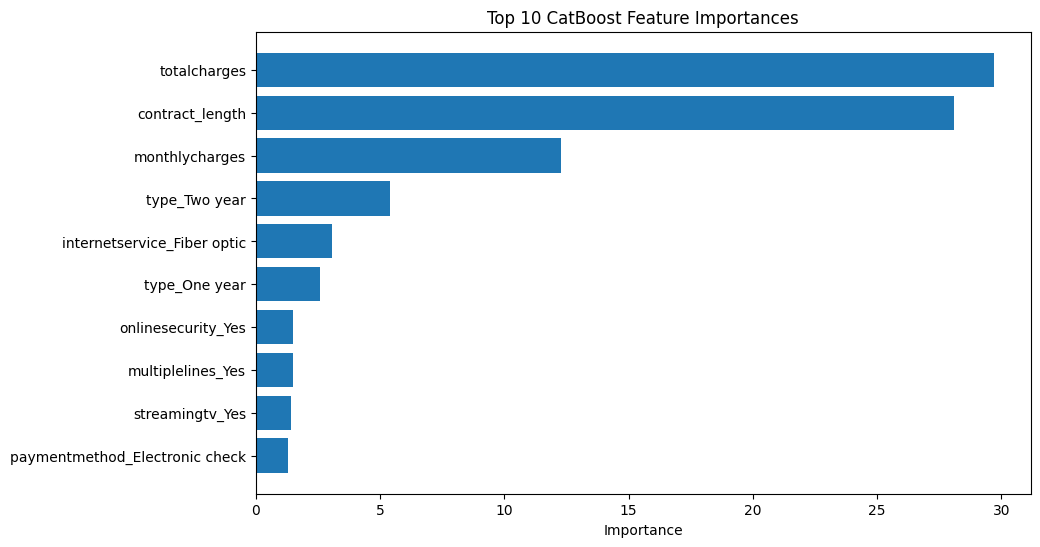

In [46]:
plt.figure(figsize=(10,6))
plt.barh(cat_importance_df['feature'][:10][::-1], cat_importance_df['importance'][:10][::-1])
plt.xlabel("Importance")
plt.title("Top 10 CatBoost Feature Importances")
plt.show()

The chart presents the top 10 most important features identified by the CatBoost model for predicting customer churn.
The features `totalcharges`, `contract_length`, and `monthlycharges` have the highest importance, indicating that overall spending, contract duration, and monthly payment amounts are the strongest predictors of customer churn. Contract type, internet service type, and several service usage features also contribute, but to a lesser extent. The importance values reflect each feature’s contribution to the model’s predictive performance.

---

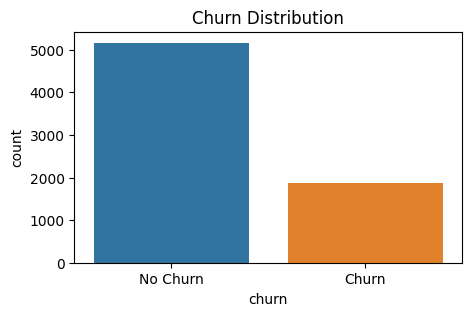

In [47]:
plt.figure(figsize=(5, 3))
sns.countplot(x='churn', data=df)
plt.title('Churn Distribution')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

The chart shows the distribution of the target variable `churn` in the dataset.
The dataset is imbalanced, with a significantly higher number of customers who have not churned compared to those who have churned. This imbalance emphasizes the importance of using evaluation metrics such as AUC-ROC rather than relying solely on accuracy.

---

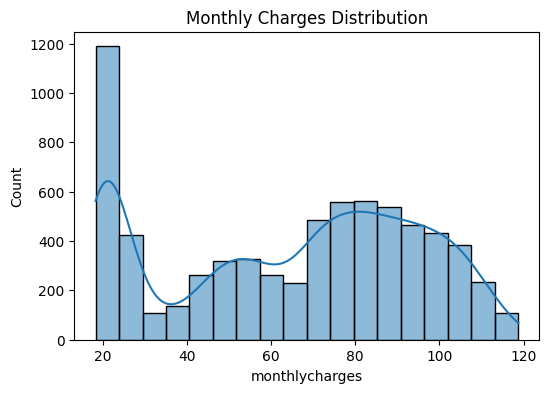

In [48]:
plt.figure(figsize=(6, 4))
sns.histplot(df['monthlycharges'], kde=True)
plt.title('Monthly Charges Distribution')
plt.show()

The chart shows the distribution of customers’ monthly charges.
The distribution is multimodal, indicating several distinct groups of customers with different pricing plans. A large number of customers are concentrated at the lower end of monthly charges, while a second peak is observed around \$80–\$90. This variation reflects different service bundles and contract types among customers, which may affect churn behavior.

---

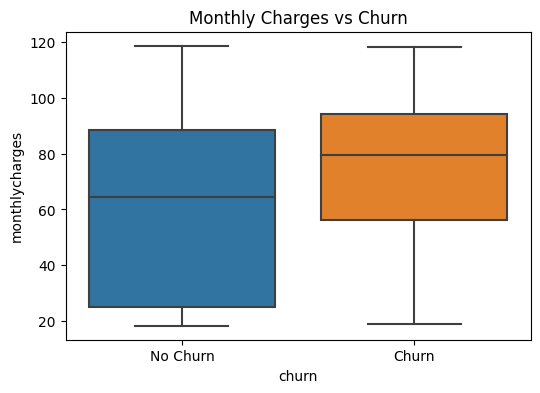

In [49]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='churn', y='monthlycharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

The boxplot compares the distribution of monthly charges between customers who churned and those who did not.
On average, churned customers tend to have higher monthly charges compared to those who stayed. This suggests that higher monthly fees may be associated with an increased likelihood of churn, making monthly charges an important feature for churn prediction.

---

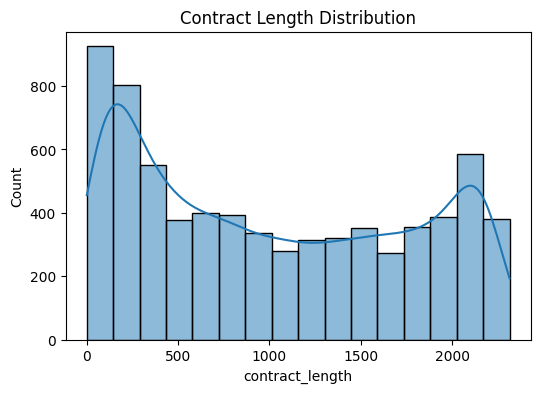

In [50]:
plt.figure(figsize=(6, 4))
sns.histplot(df['contract_length'], kde=True)
plt.title('Contract Length Distribution')
plt.show()

The histogram shows the distribution of contract length in days.
The distribution is right-skewed, with a large number of customers having relatively short contract durations, while a smaller group remains under long-term contracts. The second peak around 2000 days corresponds to customers with longer fixed-term contracts (one-year or two-year contracts). Contract length plays an important role in churn prediction, as shorter contracts are often associated with higher churn rates.

---

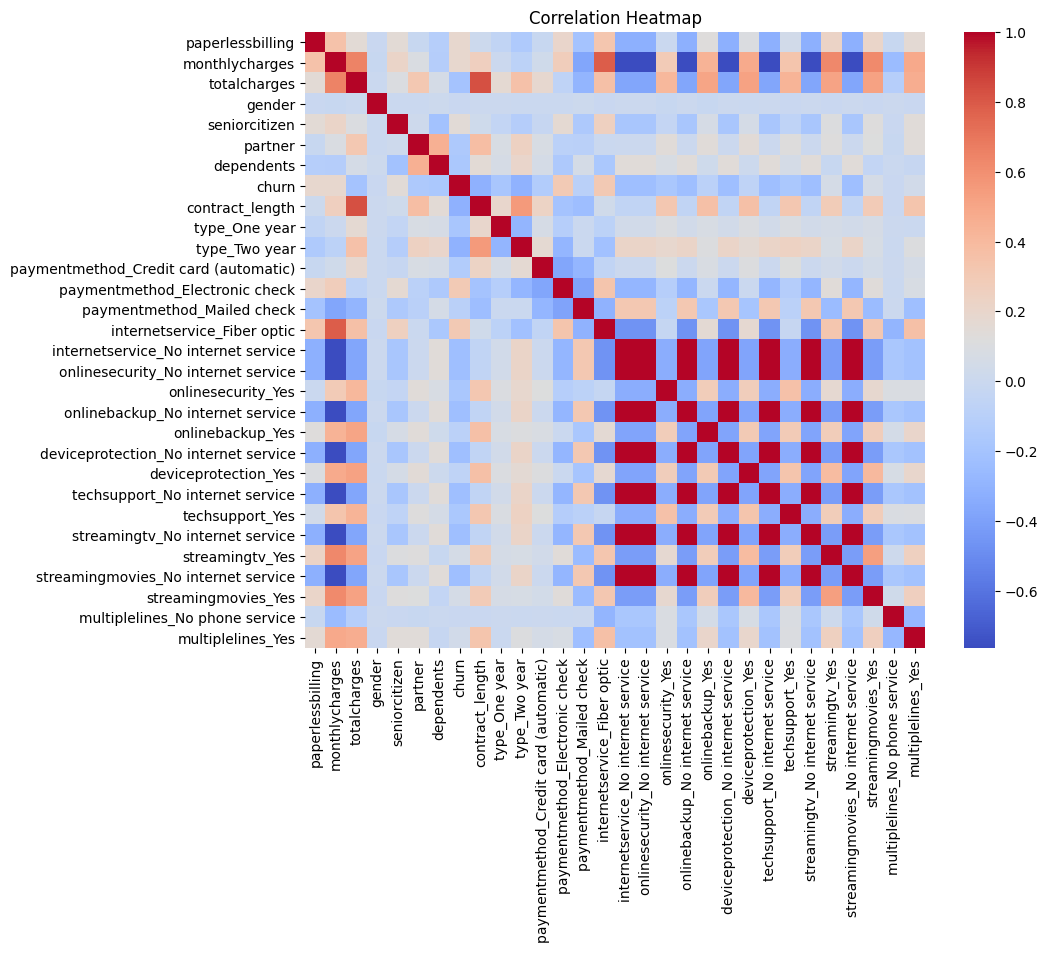

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

The heatmap displays the pairwise correlation coefficients between all features in the dataset.
Most features have low-to-moderate correlations, indicating that multicollinearity is not a major concern. Some strong positive correlations are observed among service-related features (such as streaming and internet options), while financial variables like `totalcharges`, `monthlycharges`, and `contract_length` show moderate correlations with each other and with the target variable `churn`. These financial variables are important contributors to churn prediction, as confirmed by feature importance analysis.

---

In [25]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df['begindate'] = pd.to_datetime(df['begindate'])
df['enddate'] = pd.to_datetime(df['enddate'], errors='coerce')

df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')

df['churn'] = np.where(df['enddate'].isna(), 0, 1)

df['totalcharges'] = df['totalcharges'].fillna(df['totalcharges'].median())

internet_cols = ['internetservice', 'onlinesecurity', 'onlinebackup',
                 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
df[internet_cols] = df[internet_cols].fillna('No internet service')
df['multiplelines'] = df['multiplelines'].fillna('No phone service')

df['contract_length'] = (pd.Timestamp('2020-02-01') - df['begindate']).dt.days

binary_cols = ['paperlessbilling', 'partner', 'dependents', 'gender']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

categorical_cols = ['type', 'paymentmethod', 'internetservice',
                    'onlinesecurity', 'onlinebackup', 'deviceprotection',
                    'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df = df.drop(columns=['customerid', 'begindate', 'enddate'])

duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')
df = df.drop_duplicates()

Number of duplicate rows: 13


In [31]:
X = df.drop(columns='churn')
y = df['churn']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, stratify=y_temp, test_size=0.25, random_state=42)

print(f'Train shape: {X_train.shape}')
print(f'Validation shape: {X_valid.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (4218, 29)
Validation shape: (1406, 29)
Test shape: (1406, 29)


In [40]:
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)

y_proba_valid_dummy = dummy.predict_proba(X_valid)[:, 1]
y_pred_valid_dummy = dummy.predict(X_valid)

print("Dummy Classifier Validation AUC-ROC:", roc_auc_score(y_valid, y_proba_valid_dummy))
print("Validation Accuracy:", accuracy_score(y_valid, y_pred_valid_dummy))

Dummy Classifier Validation AUC-ROC: 0.5
Validation Accuracy: 0.7347083926031295


In [35]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred_valid_lr = lr.predict(X_valid)
y_proba_valid_lr = lr.predict_proba(X_valid)[:, 1]

print("Logistic Regression Validation AUC-ROC:", roc_auc_score(y_valid, y_proba_valid_lr))
print("Validation Accuracy:", accuracy_score(y_valid, y_pred_valid_lr))

Logistic Regression Validation AUC-ROC: 0.8416958856398372
Validation Accuracy: 0.7560455192034139


In [36]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_valid_rf = rf.predict(X_valid)
y_proba_valid_rf = rf.predict_proba(X_valid)[:, 1]

print("Random Forest Validation AUC-ROC:", roc_auc_score(y_valid, y_proba_valid_rf))
print("Validation Accuracy:", accuracy_score(y_valid, y_pred_valid_rf))

Random Forest Validation AUC-ROC: 0.8852972549304584
Validation Accuracy: 0.8463726884779517


In [37]:
cat = CatBoostClassifier(verbose=0, random_state=42,
                          class_weights=[1, y_train.value_counts()[0]/y_train.value_counts()[1]])
cat.fit(X_train, y_train)

y_pred_valid_cat = cat.predict(X_valid)
y_proba_valid_cat = cat.predict_proba(X_valid)[:, 1]

print("CatBoost Validation AUC-ROC:", roc_auc_score(y_valid, y_proba_valid_cat))
print("Validation Accuracy:", accuracy_score(y_valid, y_pred_valid_cat))


CatBoost Validation AUC-ROC: 0.9313641778416804
Validation Accuracy: 0.8669985775248933


In [56]:
cat = CatBoostClassifier(
    verbose=0,
    random_state=42,
    class_weights=[1, y_train.value_counts()[0] / y_train.value_counts()[1]]
)

param_dist = {
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [200, 300, 400, 500]
}

random_search = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dist,
    n_iter=20,  
    scoring='roc_auc',
    cv=3, 
    random_state=42,
    n_jobs=-1  
)

random_search.fit(X_train, y_train)

print("Best hyperparameters:", random_search.best_params_)

best_cat = random_search.best_estimator_

y_pred_valid_cat = best_cat.predict(X_valid)
y_proba_valid_cat = best_cat.predict_proba(X_valid)[:, 1]

print("Tuned CatBoost Validation AUC-ROC:", roc_auc_score(y_valid, y_proba_valid_cat))
print("Tuned CatBoost Validation Accuracy:", accuracy_score(y_valid, y_pred_valid_cat))

y_pred_test_cat = best_cat.predict(X_test)
y_proba_test_cat = best_cat.predict_proba(X_test)[:, 1]

print("Tuned CatBoost Test AUC-ROC:", roc_auc_score(y_test, y_proba_test_cat))
print("Tuned CatBoost Test Accuracy:", accuracy_score(y_test, y_pred_test_cat))

Best hyperparameters: {'learning_rate': 0.2, 'iterations': 400, 'depth': 4}
Tuned CatBoost Validation AUC-ROC: 0.9432689088497803
Tuned CatBoost Validation Accuracy: 0.8933143669985776
Tuned CatBoost Test AUC-ROC: 0.9403699368558741
Tuned CatBoost Test Accuracy: 0.884068278805121


The goal of this project was to develop a machine learning model capable of predicting customer churn for a telecom provider. After completing data preprocessing, feature engineering, and splitting the dataset into training, validation, and test subsets, multiple models were trained and evaluated.

The performance on the validation set was as follows:

* **Dummy Classifier (baseline):**

  * AUC-ROC: **0.5000**
  * Accuracy: **73.41%**

* **Logistic Regression:**

  * AUC-ROC: **0.8417**
  * Accuracy: **75.60%**

* **Random Forest:**

  * AUC-ROC: **0.8853**
  * Accuracy: **84.64%**

* **CatBoost (initial best model):**

  * AUC-ROC: **0.9314**
  * Accuracy: **86.70%**

After hyperparameter tuning, CatBoost achieved further improvement. The final evaluation on the independent test set resulted in:

* **Tuned CatBoost Test AUC-ROC:** **0.9404**
* **Test Accuracy:** **88.41%**

The tuned CatBoost model provided the highest predictive performance, significantly surpassing both the baseline and other models. With an AUC-ROC well above the 0.88 threshold, the model successfully identifies customers at risk of churn, enabling targeted retention strategies for the company.

---

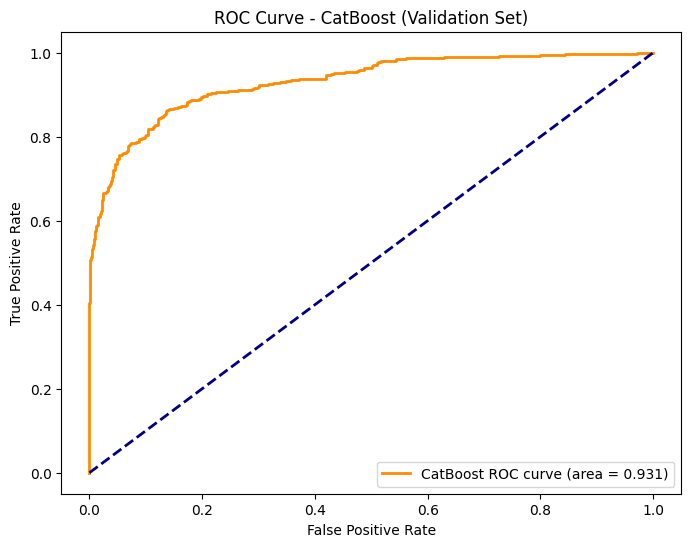

In [43]:
fpr, tpr, thresholds = roc_curve(y_valid, y_proba_valid_cat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='CatBoost ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost (Validation Set)')
plt.legend(loc="lower right")
plt.show()

The ROC curve for the CatBoost model on the validation set demonstrates strong model performance. The curve is positioned far above the diagonal reference line (which represents random guessing). The area under the curve (AUC-ROC) is approximately 0.931, indicating excellent ability of the model to distinguish between churned and non-churned customers. The closer the curve approaches the top-left corner, the better the model's classification capability, and in this case, the model shows high sensitivity and specificity.

In [9]:
rf_importances = rf.feature_importances_
rf_features = X_train.columns

rf_importance_df = pd.DataFrame({'feature': rf_features, 'importance': rf_importances})
rf_importance_df = rf_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

print("Random Forest Feature Importance:")
print(rf_importance_df.head(10))

Random Forest Feature Importance:
                          feature  importance
0                 contract_length    0.188663
1                    totalcharges    0.182144
2                  monthlycharges    0.139994
3                   type_Two year    0.067448
4     internetservice_Fiber optic    0.037729
5  paymentmethod_Electronic check    0.036190
6                   type_One year    0.032201
7                 techsupport_Yes    0.026219
8              onlinesecurity_Yes    0.024878
9                paperlessbilling    0.022551


In [10]:
cat_importances = cat.get_feature_importance()
cat_features = X_train.columns

cat_importance_df = pd.DataFrame({'feature': cat_features, 'importance': cat_importances})
cat_importance_df = cat_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

print("CatBoost Feature Importance:")
print(cat_importance_df.head(10))

CatBoost Feature Importance:
                          feature  importance
0                    totalcharges   30.667111
1                 contract_length   28.305144
2                  monthlycharges   12.892689
3                   type_Two year    5.102491
4     internetservice_Fiber optic    3.245974
5                   type_One year    2.482174
6              onlinesecurity_Yes    1.352477
7               multiplelines_Yes    1.319204
8  paymentmethod_Electronic check    1.231746
9                paperlessbilling    1.178597


Both Random Forest and CatBoost models identified the most influential features contributing to churn prediction.

* **Most important features in both models**:

  * `contract_length`
  * `totalcharges`
  * `monthlycharges`

* Additional important features include:

  * Contract type (`type_Two year`, `type_One year`)
  * Internet service type (`internetservice_Fiber optic`)
  * Security-related services (`onlinesecurity_Yes`, `techsupport_Yes`)
  * Billing-related features (`paymentmethod_Electronic check`, `paperlessbilling`)
  * Multiple phone lines (`multiplelines_Yes`)

The results are consistent across both models, confirming that contract duration, total charges, and monthly charges play a key role in customer churn.

---

The objective of this project was to build a machine learning model to predict customer churn for a telecom provider. The dataset included contract details, personal information, internet and phone service usage, which were merged, cleaned, and processed.

Exploratory data analysis (EDA) showed that the dataset was imbalanced, with a higher proportion of non-churned customers. Financial features such as `totalcharges`, `contract_length`, and `monthlycharges` demonstrated strong relationships with churn, while service-related features like contract type, internet service, and security options also contributed meaningfully to customer retention behavior.

Several machine learning models were trained and evaluated using AUC-ROC as the primary metric:

* **Dummy Classifier (baseline):**

  * AUC-ROC = **0.5000**
  * Accuracy = **73.41%**

* **Logistic Regression:**

  * AUC-ROC = **0.8417**
  * Accuracy = **75.60%**

* **Random Forest:**

  * AUC-ROC = **0.8853**
  * Accuracy = **84.64%**

* **CatBoost (before tuning):**

  * AUC-ROC = **0.9314**
  * Accuracy = **86.70%**

After hyperparameter tuning, CatBoost achieved even better performance:

* **Tuned CatBoost Validation AUC-ROC:** **0.9433**
* **Validation Accuracy:** **89.33%**

The final tuned model was then evaluated on the independent test set, achieving:

* **Tuned CatBoost Test AUC-ROC:** **0.9404**
* **Test Accuracy:** **88.41%**

Feature importance analysis confirmed that `contract_length`, `totalcharges`, and `monthlycharges` were the most influential drivers of churn. These insights were consistent across both Random Forest and CatBoost models and were visually confirmed through feature importance plots.

The final model demonstrates strong predictive capability and provides a reliable tool for identifying customers at risk of churn. This enables the company to proactively apply targeted retention strategies and reduce customer turnover.

---